<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Final-Project-Check-in" data-toc-modified-id="Final-Project-Check-in-1">Final Project Check-in</a></span></li><li><span><a href="#Group-Name" data-toc-modified-id="Group-Name-2">Group Name</a></span></li><li><span><a href="#Student-Names" data-toc-modified-id="Student-Names-3">Student Names</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-4">Load Data</a></span></li><li><span><a href="#Fit-scikit-learn-model" data-toc-modified-id="Fit-scikit-learn-model-5">Fit scikit-learn model</a></span></li><li><span><a href="#Evaluation-Metric" data-toc-modified-id="Evaluation-Metric-6">Evaluation Metric</a></span></li></ul></div>

Final Project Check-in
------

Group Name
-----

### Durian Candy 

Student Names
----

1. Andrew Young
2. Charles Siu
3. Sean Tey
4. Sunny Kwong 

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn import impute
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from rfpimp import *

Load Data
-----

In [3]:
df = pd.read_csv("../data/data_cleaned.csv")
df_copy = df.copy()

# Replace Categorical Missing Value and Do label encoding
cat_col = ['Nationality', 'Club', 'Preferred_Foot', 'Off_Work_Rate', 
           'Def_Work_Rate', 'Real_Face', 'Position', 'Loaned_Out', 'League_Country', 'League_Country']
df[cat_col] = df[cat_col].fillna(value='NA')  # fill na for categorical features
le = preprocessing.LabelEncoder()
for c in cat_col:
    df[c] = le.fit_transform(df[c])

In [4]:
y = df['Value']

In [5]:
X = df.drop('Value',axis=1)

In [6]:
# Uses best variables chosen from linear regression code
lr_vars = ['Wage', 'Release_Clause', 'Overall', 'International_Reputation', 'Age', 
           'League_Revenue', 'League_Revenue_Per_Team', 'SlidingTackle', 'Potential',
           'FKAccuracy', 'Position', 'Loaned_Out', 'Reactions', 'Marking']

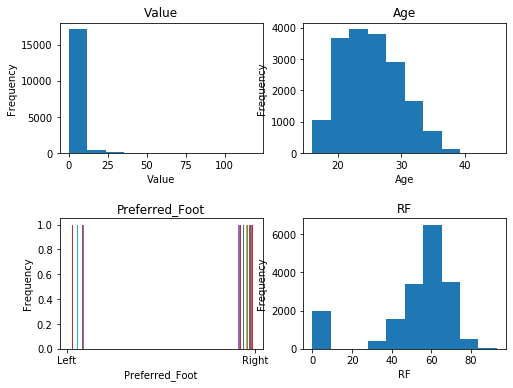

In [7]:
plt_row = 2
plt_col = 2
plt.figure(figsize = (plt_col * 4, plt_row * 3))

for i, col in enumerate(['Value', 'Age', 'Preferred_Foot', 'RF']):
    plt.subplot(plt_row, plt_col, i + 1)
    plt.subplots_adjust(hspace = 0.5)
    x = df_copy[col].dropna(axis=0)
    plt.hist(x)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')

Fit scikit-learn model
----

In [8]:
RM = RandomForestRegressor(n_estimators=30,
                                  min_samples_leaf=1,
                                  random_state=42)
lasso = linear_model.Lasso(tol=0.05)
vanilla_lr = linear_model.LinearRegression()

In [9]:
numerical_col =  list(set(df.columns) - set(cat_col))
numerical_col.remove('Value')

In [10]:
def make_pipeline(regressors=None):
    pipelines = []
    
    for regressor in regressors:
        "Create a single pipeline that processing the data and then fits the regressor." 
        median_impute = impute.SimpleImputer(strategy='median')

        numerical_names = numerical_col

        col_transform = compose.ColumnTransformer([('numerics',median_impute,numerical_names)])

        steps_list = [('col_t',col_transform),('regressor',regressor)]

        pipeline = Pipeline(steps=steps_list)
        pipelines.append(pipeline)
    
    return pipelines

In [11]:
# Have to fit two pipelines since Linear Regression has variable selection as well. 
numerical_lr_col =  list(set(lr_vars) - set(cat_col))
def make_lr_pipeline(regressors=None):
    pipelines = []
    
    for regressor in regressors:
        "Create a single pipeline that processing the data and then fits the regressor." 
        median_impute = impute.SimpleImputer(strategy='median')

        numerical_names = numerical_lr_col

        col_transform = compose.ColumnTransformer([('numerics',median_impute,numerical_names)])

        steps_list = [('col_t',col_transform),('regressor',regressor)]

        pipeline = Pipeline(steps=steps_list)
        pipelines.append(pipeline)
    
    return pipelines

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [13]:
pipelines = make_pipeline([RM, lasso])
lr_pipeline = make_lr_pipeline([vanilla_lr])

In [14]:
for pipeline in pipelines:
    pipeline.fit(X_train,y_train)
for pipeline in lr_pipeline:
    pipeline.fit(X_train[lr_vars], y_train)

Evaluation Metric
----

In [15]:
def smape(y_test, y_pred):
    return 100/len(y_test) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))

In [16]:
for pipeline in pipelines:
    scores = cross_val_score(pipeline, X, y, cv=5, n_jobs=-1, scoring=make_scorer(smape))
    print(pipeline[1])
    print('sMAPE: ', np.mean(scores))
    print('\n-------\n')
for pipeline in lr_pipeline:
    scores = cross_val_score(pipeline, X, y, cv=5, n_jobs=-1, scoring=make_scorer(smape))
    print(pipeline[1])
    print('sMAPE: ', np.mean(scores))
    print('\n-------\n')

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
sMAPE:  21.71449793647214

-------

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.05, warm_start=False)
sMAPE:  91.1584438737589

-------

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
sMAPE:  71.97271633928024

-------



### Outcome
Random Forest has the lowest sMAPE value, therefore pick Random Forest as our final model

Feature Importance
---

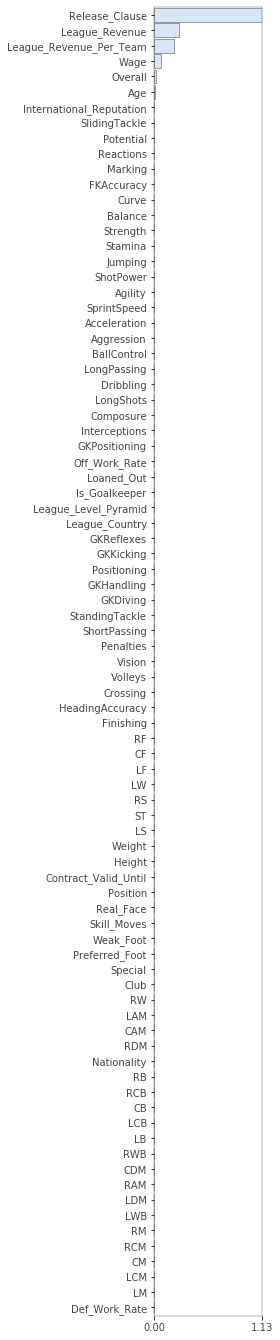

In [17]:
# original feature importance
imp = importances(pipeline, X_test, y_test) # permutation
viz = plot_importances(imp)
viz.view()

In [18]:
X_train.head()

,Age,Nationality,Overall,Potential,Club,Wage,Special,Preferred_Foot,International_Reputation,Weak_Foot,...,GKReflexes,Release_Clause,League_Country,League_Level_Pyramid,League_Revenue,League_Revenue_Per_Team,Is_Goalkeeper,Loaned_Out,Off_Work_Rate,Def_Work_Rate
2746,32,138,73,73,366,0.008,1875,1,1.0,4.0,...,10.0,5.000,19,1.0,509.0,28.0,0,0,2,2
10127,26,29,65,66,600,0.001,1792,0,1.0,3.0,...,10.0,0.891,6,1.0,113.0,6.3,0,0,0,2
6601,22,156,68,77,472,0.003,1675,1,1.0,4.0,...,13.0,2.400,33,1.0,851.0,38.7,0,0,0,2
5813,22,114,69,76,248,0.002,1115,1,1.0,3.0,...,69.0,1.600,21,1.0,152.0,9.5,1,0,2,2
14349,22,46,61,69,481,0.001,1632,1,1.0,4.0,...,12.0,0.634,12,3.0,171.0,7.1,0,0,2,2


In [19]:
# # feature importance after dropping overall, release clause, and potential

df_drop = df.drop(['Overall', 'Release_Clause', 'Potential', 'Wage'], axis=1)
cat_col = ['Nationality', 'Club', 'Preferred_Foot', 'Off_Work_Rate', 
           'Def_Work_Rate', 'Real_Face', 'Position', 'Loaned_Out', 'League_Country', 'League_Country']

numerical_col = list(set(df_drop.columns) - set(cat_col))
numerical_col.remove('Value')
df_drop[cat_col] = df_drop[cat_col].fillna(value='NA')  # fill na for categorical features
le = preprocessing.LabelEncoder()
for c in cat_col:
    df_drop[c] = le.fit_transform(df_drop[c])
y = df_drop['Value']
X = df_drop.drop('Value',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
pipeline = make_pipeline(regressor)
pipeline.fit(X_train,y_train)
median_absolute_error(y_true=y_test,y_pred=y_pred)

imp = importances(pipeline, X_test, y_test) # permutation
viz = plot_importances(imp)
viz.view()

NameError: name 'regressor' is not defined